In [12]:
import qiskit

In [13]:
#Librerie utili allo scopo
from math import sqrt, pi
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit import execute

In [14]:
#Creazione del circuito per il teletrasporto
qc = QuantumRegister(3) #Tre qubit
final = ClassicalRegister(1) #Bit finale classico -> conterrà 0 se il teletrasporto funziona
teleportation_circuit = QuantumCircuit(qc, final) #Compongo il circuito
#Circuito iniziale
teleportation_circuit.draw()

q2_0: 
      
q2_1: 
      
q2_2: 
      
c2: 1/

In [15]:
initial_state = [sqrt(0.9), sqrt(0.1)]  #AlphaQuadro=0.9 BetaQuadro=0.1
#initial_state = [sqrt(0.3), sqrt(0.7)]  #AlphaQuadro=0.3 BetaQuadro=0.7
init_state = Initialize(initial_state) #Uso questa funzione per poter dopo applicare un disentangler
init_state.label = "init"

teleportation_circuit.append(init_state, [0]) #Inizializzo primo bit con le probabilità sopra descritte
teleportation_circuit.barrier()
#Vediamo come siamo messi
teleportation_circuit.draw()

┌───────────────────────┐ ░ 
q2_0: ┤ init(0.94868,0.31623) ├─░─
      └───────────────────────┘ ░ 
q2_1: ──────────────────────────░─
                                ░ 
q2_2: ──────────────────────────░─
                                ░ 
c2: 1/════════════════════════════

In [16]:
#PRIMO STEP -> creo bit entangled
#Creo bit entangled di A e B
teleportation_circuit.h(1) #Hademard sul secondo qubit generale
teleportation_circuit.cx(1,2) #CNOT  su terzo bit  (2) controllato dal secondo (1)
#Vediamo come siamo messi
teleportation_circuit.draw()

┌───────────────────────┐ ░           
q2_0: ┤ init(0.94868,0.31623) ├─░───────────
      └───────────────────────┘ ░ ┌───┐     
q2_1: ──────────────────────────░─┤ H ├──■──
                                ░ └───┘┌─┴─┐
q2_2: ──────────────────────────░──────┤ X ├
                                ░      └───┘
c2: 1/══════════════════════════════════════

In [17]:
#SECONDO STEP -> "collego" il messaggio al qubit entangled
teleportation_circuit.barrier() #Barriera
teleportation_circuit.cx(0, 1) #CNOT su secondo bit (1) controllato dal primo bit (0)
teleportation_circuit.h(0) #Hademard sul messaggio
#Circuito aggiornato
teleportation_circuit.draw()

┌───────────────────────┐ ░            ░      ┌───┐
q2_0: ┤ init(0.94868,0.31623) ├─░────────────░───■──┤ H ├
      └───────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘
q2_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├─────
                                ░ └───┘┌─┴─┐ ░ └───┘     
q2_2: ──────────────────────────░──────┤ X ├─░───────────
                                ░      └───┘ ░           
c2: 1/═══════════════════════════════════════════════════

In [18]:
#TERZO STEP -> misura di A
#A effetuua una misura sui due qubit che ha, il risultato sarà nei registri classici
teleportation_circuit.barrier()
#teleportation_circuit.measure(0,crz) #Misura del primo qubit nel registro classico crz
#teleportation_circuit.measure(1,crx) #Misura del secondo qubit nel registro classico crx
#Circuito aggiornato
teleportation_circuit.draw()

┌───────────────────────┐ ░            ░      ┌───┐ ░ 
q2_0: ┤ init(0.94868,0.31623) ├─░────────────░───■──┤ H ├─░─
      └───────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ 
q2_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├──────░─
                                ░ └───┘┌─┴─┐ ░ └───┘      ░ 
q2_2: ──────────────────────────░──────┤ X ├─░────────────░─
                                ░      └───┘ ░            ░ 
c2: 1/══════════════════════════════════════════════════════

In [19]:
#ULTIMO STEP -> porta correttiva applicata da B
# 00 -> Niente
# 10 -> Z
# 01 -> X
# 11 -> XZ
teleportation_circuit.cx(1, 2)
teleportation_circuit.cz(0, 2)
#teleportation_circuit.x(2).c_if(crx, 1) #Applico porta di correzione X se ho 1 nel registro
#teleportation_circuit.z(2).c_if(crz, 1) #Applico porta di correzione Z se ho 1 nel registro
#Circuito aggiornato
teleportation_circuit.draw()

┌───────────────────────┐ ░            ░      ┌───┐ ░         
q2_0: ┤ init(0.94868,0.31623) ├─░────────────░───■──┤ H ├─░───────■─
      └───────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░       │ 
q2_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├──────░───■───┼─
                                ░ └───┘┌─┴─┐ ░ └───┘      ░ ┌─┴─┐ │ 
q2_2: ──────────────────────────░──────┤ X ├─░────────────░─┤ X ├─■─
                                ░      └───┘ ░            ░ └───┘   
c2: 1/══════════════════════════════════════════════════════════════

In [20]:
#Disentangler
inverse_init_state = init_state.gates_to_uncompute() #Porta che mi dovrebbe dare sempre 0
teleportation_circuit.append(inverse_init_state, [2]) #Applico trasformazione inversa
#Circuito aggiornato
teleportation_circuit.draw()

┌───────────────────────┐ ░            ░      ┌───┐ ░         »
q2_0: ┤ init(0.94868,0.31623) ├─░────────────░───■──┤ H ├─░───────■─»
      └───────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░       │ »
q2_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├──────░───■───┼─»
                                ░ └───┘┌─┴─┐ ░ └───┘      ░ ┌─┴─┐ │ »
q2_2: ──────────────────────────░──────┤ X ├─░────────────░─┤ X ├─■─»
                                ░      └───┘ ░            ░ └───┘   »
c2: 1/══════════════════════════════════════════════════════════════»
                                                                    »
«                      
«q2_0: ────────────────
«                      
«q2_1: ────────────────
«      ┌──────────────┐
«q2_2: ┤ disentangler ├
«      └──────────────┘
«c2: 1/════════════════
«

In [21]:
#Misura finale, se tutto è andato bene dovrei avere 0 nell'ultimo bit
teleportation_circuit.measure(2,0)
teleportation_circuit.draw()

┌───────────────────────┐ ░            ░      ┌───┐ ░         »
q2_0: ┤ init(0.94868,0.31623) ├─░────────────░───■──┤ H ├─░───────■─»
      └───────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░       │ »
q2_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├──────░───■───┼─»
                                ░ └───┘┌─┴─┐ ░ └───┘      ░ ┌─┴─┐ │ »
q2_2: ──────────────────────────░──────┤ X ├─░────────────░─┤ X ├─■─»
                                ░      └───┘ ░            ░ └───┘   »
c2: 1/══════════════════════════════════════════════════════════════»
                                                                    »
«                         
«q2_0: ───────────────────
«                         
«q2_1: ───────────────────
«      ┌──────────────┐┌─┐
«q2_2: ┤ disentangler ├┤M├
«      └──────────────┘└╥┘
«c2: 1/═════════════════╩═
«                       0

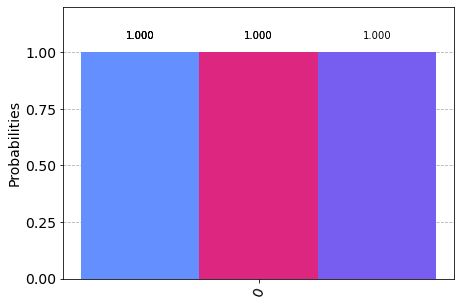

In [22]:
#SIMULAZIONE ESPERIMENTO
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(teleportation_circuit, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

In [23]:
#TEST REALE
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 256

#IBMQ.save_account('763d3f05bcdfd873126de6c85ed191521de9c65651ec42a52b18c317a58f6f5a27ef69b8bf81575f0ae531c4d1e8c9e70068f586bf5d140a00a066437adf6ca7')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("COMPUTER SCELTO: ", backend)
#EXEC
job = execute(teleportation_circuit, backend=backend, shots=shots)

COMPUTER SCELTO:  ibmq_lima


In [24]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


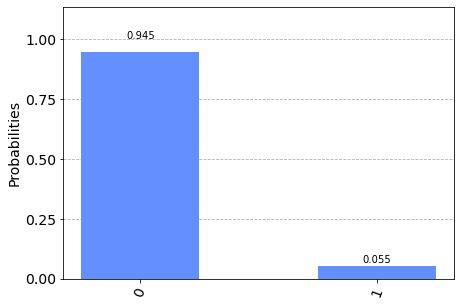

In [25]:
#RISULTATI
#0 successo - 1 fallito
result = job.result()
plot_histogram(result.get_counts(teleportation_circuit))